In [281]:
library(dplyr)
library(ggplot2)
library(DESeq2)
library(DOSE)
library(tibble)
library(pheatmap)
library(wesanderson)
library(RColorBrewer)
library(variancePartition)
library(reshape2)
library(org.Dm.eg.db)
library(clusterProfiler)
library(edgeR)
library(babelgene)
library(ggpubr)
library(circlize)
library(ComplexHeatmap)

In [167]:
data <- read.table("../Data/Drosophila_experiment/raw_counts_drosophila.csv", sep = ",", header = T, row.names = 1)

In [168]:
head(data)

,S6_F_DMSO_REP1,S6_F_DMSO_REP2,S6_F_DMSO_REP3,S6_F_TDO2_REP1,S6_F_TDO2_REP2,S6_F_TDO2_REP3,WT_F_DMSO_REP1,WT_F_DMSO_REP2,WT_F_DMSO_REP3,WT_F_TDO2_REP1,WT_F_TDO2_REP2,WT_F_TDO2_REP3,gene_name
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
FBgn0000003,462866.957,391549.552,444239.326,558239.572,539980.500,372060.686,490438.850,602258.097,560945.449,594994.540,467332.802,369520.446,7SLRNA:CR32864
FBgn0000008,2308.684,1682.821,2667.496,2287.047,2362.480,1786.446,1536.569,3434.190,1907.584,1671.720,1715.403,1530.401,a
FBgn0000014,53.081,131.491,96.136,57.247,83.647,125.767,68.966,136.092,182.677,118.398,52.059,103.696,abd-A
FBgn0000015,729.811,715.815,1146.175,713.817,827.152,810.475,809.886,844.677,1036.794,551.364,576.631,727.515,Abd-B
FBgn0000017,5458.454,4849.032,6874.185,6880.048,6491.262,4973.146,3684.338,9950.155,4391.060,5208.849,3755.044,4208.084,Abl
FBgn0000018,219.464,230.000,304.784,267.999,243.655,217.155,128.994,335.004,294.995,193.799,239.290,233.796,abo


In [169]:
samplenames <- colnames(data)[-ncol(data)]

In [170]:
meta <- strsplit(samplenames, split = "_") %>% as.data.frame() %>% t()

In [171]:
rownames(meta) <- samplenames
colnames(meta) <- c('Genotype', 'Sex', 'Treatment', 'Replicate')
meta <- as.data.frame(meta)

In [172]:
ann.data <- data %>% dplyr::select(gene_name) %>% rownames_to_column("ENSEMBL")

In [173]:
data <- data %>% select(rownames(meta)) %>% .[rowSums(.) > 20, ]

In [174]:
meta$Factors <- paste(meta$Genotype, meta$Treatment, sep = '_')

## Quality Control

In [175]:
dds <- DESeqDataSetFromMatrix(countData = round(data), colData = meta, design = ~ 1)

converting counts to integer mode



In [176]:
filterByExpr_custom  <- function(mtx, groups, min_samples = 2, min_expression = 1){
    unique_groups <- unique(groups)
    keep_genes <- rep(FALSE, nrow(mtx))
    for (i in 1:nrow(mtx)){
        keep_gene_current <- TRUE
        for(group_name in unique_groups){
            group_indices <- which(groups == group_name)
            group_counts <- mtx[i, group_indices, drop = FALSE]
            samples_with_exp <- sum(group_counts > min_expression)
            if(samples_with_exp < min_samples){
                keep_gene_current <- FALSE
                break
            }
        }
        keep_genes[i] <- keep_gene_current
    }
    
    return(keep_genes)
}

In [177]:
dds <- dds[filterByExpr_custom(assay(dds), meta$Factors, min_samples = 1, min_expression = 1), ]

In [178]:
dds <- estimateSizeFactors(dds)

In [179]:
normalized_counts <- counts(dds, normalized=TRUE)

In [180]:
rld <- rlog(dds, blind = TRUE)

In [181]:
plotPCA.mystyle <- function (object, intgroup = "condition", ntop = 500, returnData = FALSE)
{
    font.size <- 15
    rv <- rowVars(assay(object))
    r <- assay(object)
    select <- order(rv, decreasing = TRUE)[seq_len(min(ntop, length(rv)))]
    pca <- prcomp(t(assay(object)[select, ]))
    percentVar <- pca$sdev^2/sum(pca$sdev^2)
    
    d1 <- data.frame(PC1 = pca$x[, 1], PC2 = pca$x[, 2], 
                     Genotype = meta.f$Genotype,
                     Treatment = meta.f$Treatment, name = colnames(object))

    p1 <- ggplot(data = d1, aes_string(x = "PC1", y = "PC2")) +
        geom_point(aes_string(color = "Genotype", shape = "Treatment"), size = 3) +
        scale_size_manual(values=c(2, 4))+
        scale_color_manual(values = c("#B22222", "steelblue"))+
        xlab(paste0("PC1: ", round(percentVar[1] * 100), "% variance")) + 
        ylab(paste0("PC2: ", round(percentVar[2] * 100), "% variance")) +
        theme_dose(font.size = font.size)+ 
        theme(legend.title=element_text(size = 13), legend.text=element_text(size = 12))
    
    return (p1)
} 

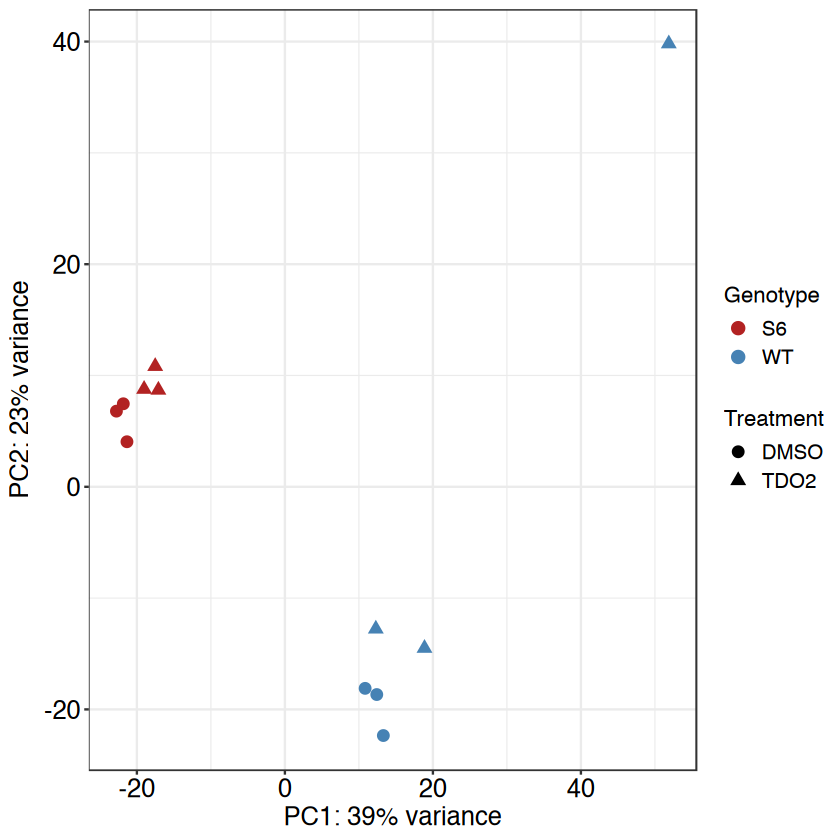

In [182]:
plotPCA.mystyle(rld)

In [183]:
d.cor <- cor(assay(rld), method = 'pearson')

In [184]:
col.pal <- colorRampPalette(c("steelblue", "white", "#D14f4f"))(50)
pal <- brewer.pal(n = 11, name = "BrBG")

In [185]:
ann_colors = list(
    Genotype = c(S6 = wes_palette("GrandBudapest1")[3], WT = wes_palette("GrandBudapest1")[4]),
    Treatment = c(DMSO = wes_palette("Moonrise2")[3], TDO2 = wes_palette("Moonrise2")[1])
)

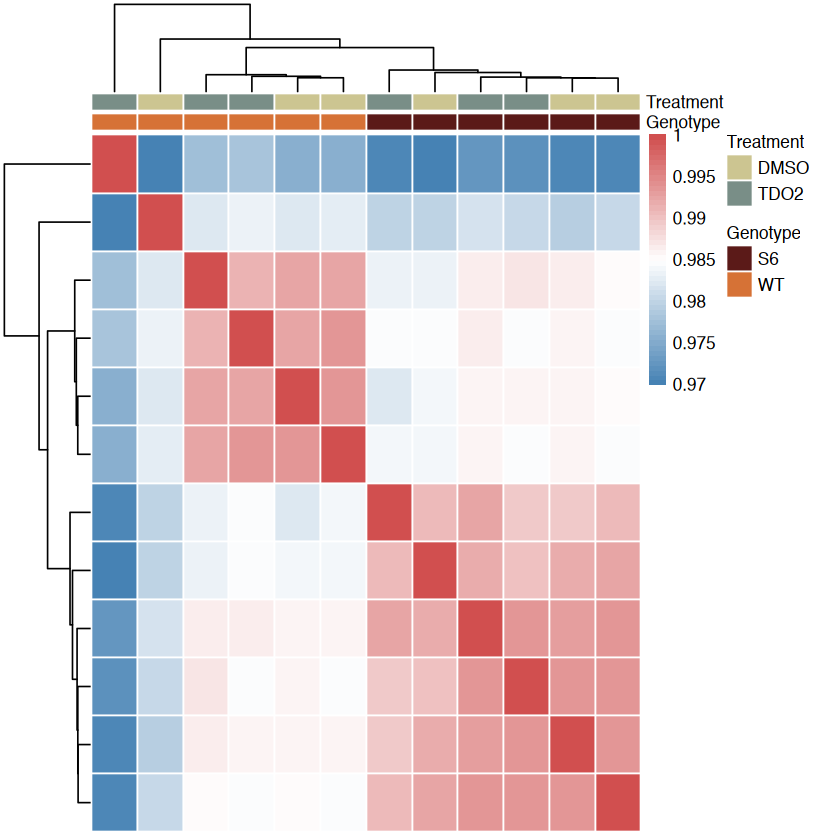

In [186]:
f1 <- pheatmap(d.cor,
         annotation_col = meta[,c(1,3)],
         color = col.pal,
         clustering_method = "average",
         annotation_colors = ann_colors,
         border_color = "white",
         show_colnames = FALSE,
         show_rownames = FALSE,
         fontsize = 10, 
         fontsize_row = 10, 
         height = 20)

## Differential expression analysis

In [187]:
dds <- DESeqDataSetFromMatrix(countData = round(data), colData = meta, design = ~ Factors)

converting counts to integer mode

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”


In [188]:
dds <- dds[filterByExpr_custom(assay(dds), meta.f$Factors, min_samples = 1, min_expression = 1), ]

In [189]:
rld <- rlog(dds, blind = TRUE)

In [190]:
dds_factors <- DESeq(dds)

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



TDO2 vs DMSO

In [191]:
contrast_wt <- c("Factors", "WT_TDO2", "WT_DMSO")
contrast_s6 <- c("Factors", "S6_TDO2", "S6_DMSO")

S6 vs WT

In [192]:
contrast_dmso <- c("Factors", "S6_DMSO", "WT_DMSO")
contrast_tdo <- c("Factors", "S6_TDO2", "WT_TDO2")

In [193]:
res_unshrunken_wt <- results(dds_factors, contrast = contrast_wt, alpha = 0.05)
res_unshrunken_s6 <- results(dds_factors, contrast = contrast_s6, alpha = 0.05)

res_unshrunken_dmso <- results(dds_factors, contrast = contrast_dmso, alpha = 0.05)
res_unshrunken_tdo <- results(dds_factors, contrast = contrast_tdo, alpha = 0.05)

In [194]:
res_wt <- lfcShrink(dds_factors, contrast = contrast_wt, res = res_unshrunken_wt, type = 'ashr')
res_s6 <- lfcShrink(dds_factors, contrast = contrast_s6, res = res_unshrunken_s6, type = 'ashr')

res_dmso <- lfcShrink(dds_factors, contrast = contrast_dmso, res = res_unshrunken_dmso, type = 'ashr')
res_tdo <- lfcShrink(dds_factors, contrast = contrast_tdo, res = res_unshrunken_tdo, type = 'ashr')

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041



In [195]:
summary(res_wt)
summary(res_s6)


out of 18751 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 10, 0.053%
LFC < 0 (down)     : 6, 0.032%
outliers [1]       : 339, 1.8%
low counts [2]     : 728, 3.9%
(mean count < 3)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results


out of 18751 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 45, 0.24%
LFC < 0 (down)     : 7, 0.037%
outliers [1]       : 339, 1.8%
low counts [2]     : 3632, 19%
(mean count < 10)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



In [196]:
summary(res_tdo)
summary(res_dmso)


out of 18751 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 832, 4.4%
LFC < 0 (down)     : 628, 3.3%
outliers [1]       : 339, 1.8%
low counts [2]     : 2182, 12%
(mean count < 6)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results


out of 18751 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 901, 4.8%
LFC < 0 (down)     : 721, 3.8%
outliers [1]       : 339, 1.8%
low counts [2]     : 2182, 12%
(mean count < 6)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



In [197]:
padj.cutoff <- 0.05

##### TDO2 vs DMSO

In [198]:
res_wt_tb <- res_wt %>%
  data.frame() %>%
  rownames_to_column(var="gene") %>% 
  as_tibble()

res_s6_tb <- res_s6 %>%
  data.frame() %>%
  rownames_to_column(var="gene") %>% 
  as_tibble()

In [199]:
sig_wt <- res_wt_tb %>%
    dplyr::filter(padj < padj.cutoff & abs(log2FoldChange) > lfc.cutoff) %>% arrange(padj)

sig_s6 <- res_s6_tb %>%
    dplyr::filter(padj < padj.cutoff & abs(log2FoldChange) > lfc.cutoff) %>% arrange(padj)

In [200]:
sig_wt <- ann.data %>% left_join(sig_wt, ., by = c("gene" = "ENSEMBL"))
sig_s6 <- ann.data %>% left_join(sig_s6, ., by = c("gene" = "ENSEMBL"))

Number of differentially expressed genes in TDO2 vs DMSO

In [201]:
nrow(sig_wt)

[1] 16

In [202]:
nrow(sig_s6)

[1] 52

In [203]:
res_wt_tb <- ann.data %>% left_join(res_wt_tb, ., by = c("gene" = "ENSEMBL"))
res_s6_tb <- ann.data %>% left_join(res_s6_tb, ., by = c("gene" = "ENSEMBL"))

##### S6 vs WT

In [204]:
res_dmso_tb <- res_dmso %>%
  data.frame() %>%
  rownames_to_column(var="gene") %>% 
  as_tibble()

res_tdo_tb <- res_tdo %>%
  data.frame() %>%
  rownames_to_column(var="gene") %>% 
  as_tibble()

In [205]:
sig_dmso <- res_dmso_tb %>%
    dplyr::filter(padj < padj.cutoff & abs(log2FoldChange) > lfc.cutoff) %>% arrange(padj)

sig_tdo <- res_tdo_tb %>%
    dplyr::filter(padj < padj.cutoff & abs(log2FoldChange) > lfc.cutoff) %>% arrange(padj)

In [206]:
sig_tdo <- ann.data %>% left_join(sig_tdo, ., by = c("gene" = "ENSEMBL"))
sig_dmso <- ann.data %>% left_join(sig_dmso, ., by = c("gene" = "ENSEMBL"))

In [207]:
res_tdo_tb <- ann.data %>% left_join(res_tdo_tb, ., by = c("gene" = "ENSEMBL"))
res_dmso_tb <- ann.data %>% left_join(res_dmso_tb, ., by = c("gene" = "ENSEMBL"))

In [208]:
res_dmso_tb %>% dplyr::filter(padj < padj.cutoff) %>% nrow()
res_tdo_tb %>% dplyr::filter(padj < padj.cutoff) %>% nrow()

[1] 1622

[1] 1460

Number of differentially expressed genes in S6 vs WT

In [209]:
sig_tdo %>% dim()

[1] 1460    7

In [210]:
sig_dmso %>% dim()

[1] 1622    7

## Volcano plots

In [211]:
library(EnhancedVolcano)

S6 vs WT

In [212]:
res_dmso_tb <- filter(res_dmso_tb, padj != "NA")
res_dmso_tb$Sig <- 'NS'
res_dmso_tb[((res_dmso_tb$padj < 0.05) & (res_dmso_tb$log2FoldChange < -lfc.cutoff)), c(8)] <- 'Down'
res_dmso_tb[((res_dmso_tb$padj < 0.05) & (res_dmso_tb$log2FoldChange > lfc.cutoff)), c(8)] <- 'Up'

names.keyvals <- res_dmso_tb$Sig
names.keyvals[names.keyvals == 'NS'] <- 'grey'
names.keyvals[names.keyvals == 'Down'] <- wes_palette("IsleofDogs1")[1]
names.keyvals[names.keyvals == 'Up'] <- wes_palette("IsleofDogs2")[3]

names(names.keyvals) <- res_dmso_tb$Sig

In [213]:
res_tdo_tb <- filter(res_tdo_tb, padj != "NA")
res_tdo_tb$Sig <- 'NS'
res_tdo_tb[((res_tdo_tb$padj < 0.05) & (res_tdo_tb$log2FoldChange < -lfc.cutoff)), c(8)] <- 'Down'
res_tdo_tb[((res_tdo_tb$padj < 0.05) & (res_tdo_tb$log2FoldChange > lfc.cutoff)), c(8)] <- 'Up'

names.keyvals_tdo <- res_tdo_tb$Sig
names.keyvals_tdo[names.keyvals_tdo == 'NS'] <- 'grey'
names.keyvals_tdo[names.keyvals_tdo == 'Down'] <- wes_palette("IsleofDogs1")[1]
names.keyvals_tdo[names.keyvals_tdo == 'Up'] <- wes_palette("IsleofDogs2")[3]

names(names.keyvals_tdo) <- res_tdo_tb$Sig

In [214]:
p1 <- EnhancedVolcano(res_dmso_tb, 
        lab = res_dmso_tb$gene_name,
        selectLab = res_dmso_tb %>% arrange(padj) %>% head(10) %>% .$gene_name,
        x = 'log2FoldChange',
        y = 'padj',
        xlim = c(-10, 10),
        #ylim = c(0, 25),
        title = NULL,
        #col = c('grey', 'grey', 'grey', '#D14f4f'),
    colCustom = names.keyvals,
    #shapeCustom = shapes.keyvals,
    cutoffLineType = 'twodash',
    subtitle = NULL,
    colAlpha = 0.7,
    pCutoff = Inf,
    FCcutoff = Inf,
    borderWidth = 0.02,
    pointSize = 4.5,
    drawConnectors = T,
    #lengthConnectors = unit(0.01, "npc"),
    #widthConnectors = 0.8,
    legendLabels=c('', 'Not sig', 'Sig'),
    caption = NULL,
    captionLabSize = 46,
    max.overlaps = 8,
    labSize = 3.5)+
    ggtitle("S6 vs WT, DMSO")+
    theme_dose(20)+
    theme(legend.text=element_text(size=12), 
          legend.title = element_blank(), 
          legend.justification = c("right", "top"), plot.title = element_text(size = 15))

p2 <- EnhancedVolcano(res_tdo_tb, 
        lab = res_tdo_tb$gene_name,
        selectLab = res_tdo_tb %>% arrange(padj) %>% head(10) %>% .$gene_name,
        x = 'log2FoldChange',
        y = 'padj',
        xlim = c(-10, 10),
        #ylim = c(0, 25),
        title = NULL,
        #col = c('grey', 'grey', 'grey', '#D14f4f'),
    colCustom = names.keyvals_tdo,
    #shapeCustom = shapes.keyvals,
    cutoffLineType = 'twodash',
    subtitle = NULL,
    colAlpha = 0.7,
    pCutoff = Inf,
    FCcutoff = Inf,
    borderWidth = 0.02,
    pointSize = 4.5,
    max.overlaps = 7,
    drawConnectors = T,
    #min.segment.length = 0.00001,
    lengthConnectors = unit(0.01, "npc"),
    widthConnectors = 0.8,
    legendLabels=c('', 'Not sig', 'Sig'),
    caption = NULL,
    captionLabSize = 46,
    labSize = 3.5)+
    ggtitle("S6 vs WT, TDO")+
    theme_dose(20)+
    theme(legend.text=element_text(size=12), 
          legend.title = element_blank(), 
          legend.justification = c("right", "top"), plot.title = element_text(size = 15))

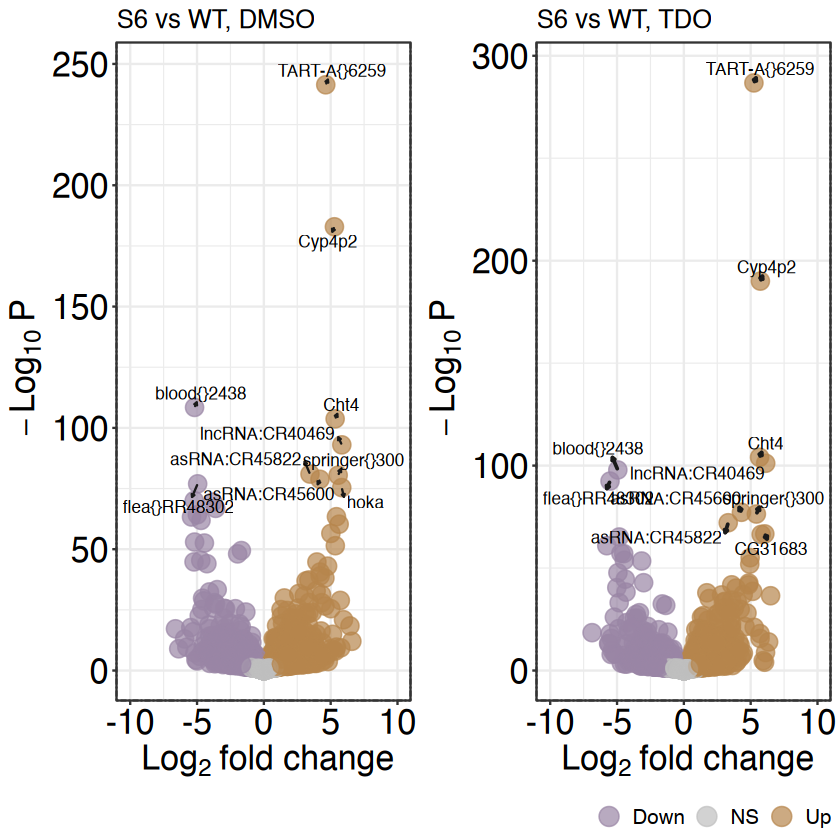

In [215]:
ggpubr::ggarrange(p1, p2, common.legend = T, legend = "bottom")

TDO2 vs DMSO

In [216]:
res_wt_tb <- filter(res_wt_tb, padj != "NA")
res_wt_tb$Sig <- 'NS'
res_wt_tb[((res_wt_tb$padj < 0.05) & (res_wt_tb$log2FoldChange < -lfc.cutoff)), c(8)] <- 'Down'
res_wt_tb[((res_wt_tb$padj < 0.05) & (res_wt_tb$log2FoldChange > lfc.cutoff)), c(8)] <- 'Up'

names.keyvals <- res_wt_tb$Sig
names.keyvals[names.keyvals == 'NS'] <- 'grey'
names.keyvals[names.keyvals == 'Down'] <- wes_palette("IsleofDogs1")[1]
names.keyvals[names.keyvals == 'Up'] <- wes_palette("IsleofDogs2")[3]

names(names.keyvals) <- res_wt_tb$Sig

In [217]:
res_s6_tb <- filter(res_s6_tb, padj != "NA")
res_s6_tb$Sig <- 'NS'
res_s6_tb[((res_s6_tb$padj < 0.05) & (res_s6_tb$log2FoldChange < -lfc.cutoff)), c(8)] <- 'Down'
res_s6_tb[((res_s6_tb$padj < 0.05) & (res_s6_tb$log2FoldChange > lfc.cutoff)), c(8)] <- 'Up'

names.keyvals_tdo <- res_s6_tb$Sig
names.keyvals_tdo[names.keyvals_tdo == 'NS'] <- 'grey'
names.keyvals_tdo[names.keyvals_tdo == 'Down'] <- wes_palette("IsleofDogs1")[1]
names.keyvals_tdo[names.keyvals_tdo == 'Up'] <- wes_palette("IsleofDogs2")[3]

names(names.keyvals_tdo) <- res_s6_tb$Sig

In [218]:
p1 <- EnhancedVolcano(res_wt_tb, 
        lab = res_wt_tb$gene_name,
        selectLab = res_wt_tb %>% arrange(padj) %>% head(10) %>% .$gene_name,
        x = 'log2FoldChange',
        y = 'padj',
        xlim = c(-4, 6),
        #ylim = c(0, 25),
        title = NULL,
        #col = c('grey', 'grey', 'grey', '#D14f4f'),
    colCustom = names.keyvals,
    #shapeCustom = shapes.keyvals,
    cutoffLineType = 'twodash',
    subtitle = NULL,
    colAlpha = 0.7,
    pCutoff = Inf,
    FCcutoff = Inf,
    borderWidth = 0.02,
    pointSize = 4.5,
    drawConnectors = T,
    #lengthConnectors = unit(0.01, "npc"),
    #widthConnectors = 0.8,
    legendLabels=c('', 'Not sig', 'Sig'),
    caption = NULL,
    captionLabSize = 46,
    max.overlaps = 8,
    labSize = 3.5)+
    ggtitle("TDO2 vs DMSO, WT")+
    theme_dose(20)+
    theme(legend.text=element_text(size=12), 
          legend.title = element_blank(), 
          legend.justification = c("right", "top"), plot.title = element_text(size = 15))

p2 <- EnhancedVolcano(res_s6_tb, 
        lab = res_s6_tb$gene_name,
        selectLab = res_s6_tb %>% arrange(padj) %>% head(18) %>% .$gene_name,
        x = 'log2FoldChange',
        y = 'padj',
        xlim = c(-4, 6),
        #ylim = c(0, 25),
        title = NULL,
        #col = c('grey', 'grey', 'grey', '#D14f4f'),
    colCustom = names.keyvals_tdo,
    #shapeCustom = shapes.keyvals,
    cutoffLineType = 'twodash',
    subtitle = NULL,
    colAlpha = 0.7,
    pCutoff = Inf,
    FCcutoff = Inf,
    borderWidth = 0.02,
    pointSize = 4.5,
    max.overlaps = 15,
    drawConnectors = T,
    #min.segment.length = 0.00001,
    lengthConnectors = unit(0.01, "npc"),
    widthConnectors = 0.8,
    legendLabels=c('', 'Not sig', 'Sig'),
    caption = NULL,
    captionLabSize = 46,
    labSize = 3.5)+
    ggtitle("TDO2 vs DMSO, S6")+
    theme_dose(20)+
    theme(legend.text=element_text(size=12), 
          legend.title = element_blank(), 
          legend.justification = c("right", "top"), plot.title = element_text(size = 15))

Warning message:
“ggrepel: 1 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


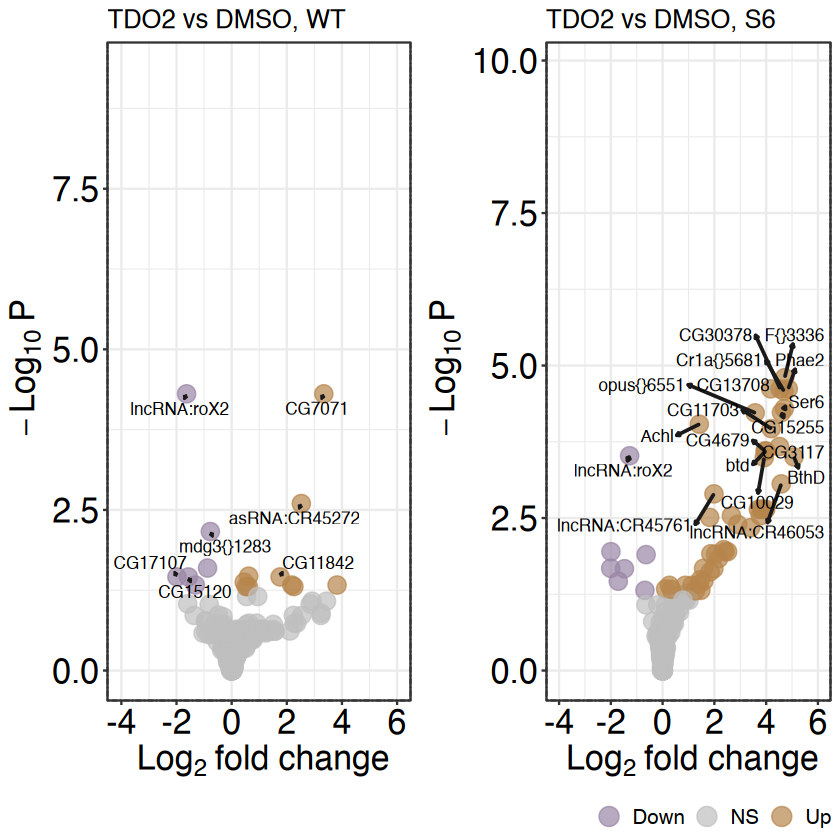

In [219]:
ggpubr::ggarrange(p1, p2, common.legend = T, legend = "bottom")

## Gene Ontology analysis

Down-regulated genes

In [220]:
ego.sig_tdo <- enrichGO(gene = filter(sig_tdo, log2FoldChange < 0)$gene, 
                        universe = rownames(res_tdo),
                        keyType = "ENSEMBL",
                        OrgDb = org.Dm.eg.db, 
                        ont = "BP", 
                        pAdjustMethod = "BH", 
                        pvalueCutoff = 0.05, 
                        readable = FALSE)

ego.sig_dmso <- enrichGO(gene = filter(sig_dmso, log2FoldChange < 0)$gene, 
                        universe = rownames(res_dmso),
                        keyType = "ENSEMBL",
                        OrgDb = org.Dm.eg.db, 
                        ont = "BP", 
                        pAdjustMethod = "BH", 
                        pvalueCutoff = 0.05, 
                        readable = FALSE)

df.sig_tdo <- as.data.frame(simplify(ego.sig_tdo, cutoff = 0.7, by = "p.adjust", select_fun = min))
df.sig_dmso <- as.data.frame(simplify(ego.sig_dmso, cutoff = 0.7, by = "p.adjust", select_fun = min))

df.sig_tdo$log10P <- -log10(df.sig_tdo$p.adjust)
df.sig_dmso$log10P <- -log10(df.sig_dmso$p.adjust)

df.sig_tdo$Description <- factor(df.sig_tdo$Description, levels = rev(df.sig_tdo$Description))
df.sig_dmso$Description <- factor(df.sig_dmso$Description, levels = rev(df.sig_dmso$Description))

In [222]:
f.tdo <- ggplot(data = df.sig_tdo, aes_string(x = "log10P", y = "Description")) +
                geom_point(aes_string(size = "Count"), color = wes_palette("Moonrise2")[1], shape = 16) + 
                xlab(NULL) + 
                ylab(NULL) +
                scale_size(name = "Hits", range = c(2, 8), limits = c(5, 33), , breaks = seq(5, 33, 8))+
                scale_x_continuous(limits = c(1, 3), breaks = seq(1,6))+
                ggtitle("S6 vs WT, TDO2") +
                geom_vline(xintercept = -log10(0.05), linetype = 2) +
                theme_dose(font.size = 16)+
                theme(plot.title = element_text(size=16), 
                      legend.key = element_rect(colour = NA, fill = NA),
                      legend.title = element_text(size = 16), 
                      legend.text = element_text(size=16))


In [223]:
f.dmso <- ggplot(data = df.sig_dmso, aes_string(x = "log10P", y = "Description")) +
                geom_point(aes_string(size = "Count"), color = wes_palette("Moonrise2")[1], shape = 16) + 
                xlab(expression("-log"["10"]~"(FDR p-value)")) + 
                ylab(NULL) +
                scale_size(name = "Hits", range = c(2, 8), limits = c(5, 33), breaks = seq(5, 33, 8))+
                scale_x_continuous(limits = c(1, 3), breaks = seq(1,6))+
                ggtitle("S6 vs WT, DMSO") +
                geom_vline(xintercept = -log10(0.05), linetype = 2)+
                theme_dose(font.size = 16)+
                theme(plot.title = element_text(size=16),
                    legend.key = element_rect(colour = NA, fill = NA),
                    legend.title = element_text(size = 16), 
                    legend.text = element_text(size=16))

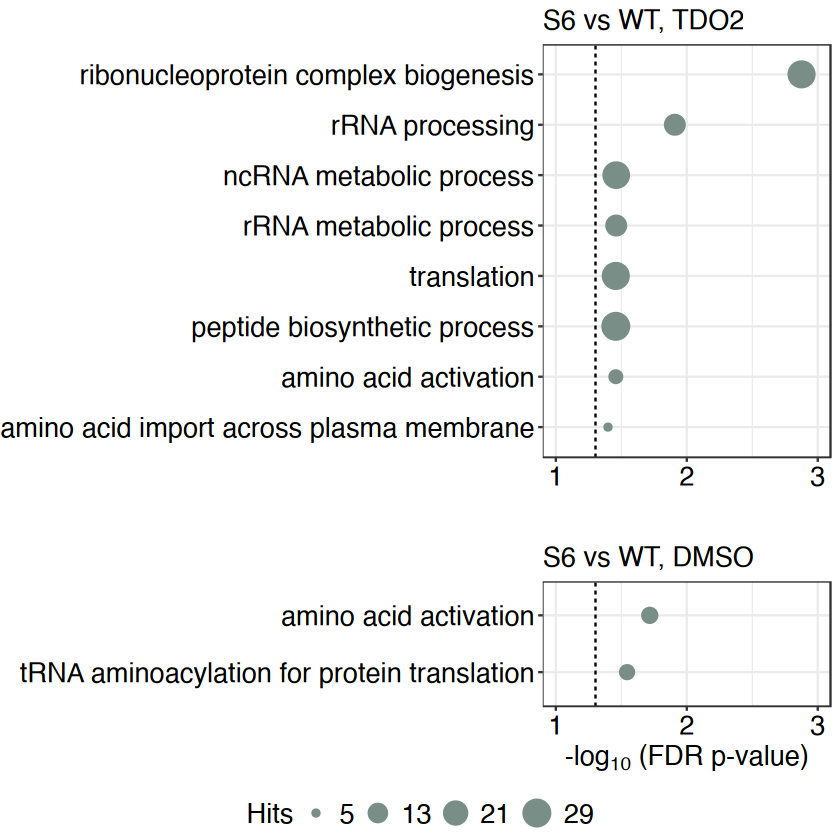

In [224]:
ggarrange(f.tdo, f.dmso, 
          ncol = 1, nrow = 2, 
          common.legend = T, 
          legend = "bottom", 
          align = "hv", 
          heights = c(4.1,1.9))

Up-regulated genes

In [225]:
ego.sig_tdo <- enrichGO(gene = filter(sig_tdo, log2FoldChange > 0)$gene, 
                        universe = rownames(res_tdo),
                        keyType = "ENSEMBL",
                        OrgDb = org.Dm.eg.db, 
                        ont = "BP", 
                        pAdjustMethod = "BH", 
                        pvalueCutoff = 0.05, 
                        readable = FALSE)

ego.sig_dmso <- enrichGO(gene = filter(sig_dmso, log2FoldChange > 0)$gene, 
                        universe = rownames(res_dmso),
                        keyType = "ENSEMBL",
                        OrgDb = org.Dm.eg.db, 
                        ont = "BP", 
                        pAdjustMethod = "BH", 
                        pvalueCutoff = 0.05, 
                        readable = FALSE)

df.sig_tdo <- as.data.frame(simplify(ego.sig_tdo, cutoff = 0.7, by = "p.adjust", select_fun = min))
df.sig_dmso <- as.data.frame(simplify(ego.sig_dmso, cutoff = 0.7, by = "p.adjust", select_fun = min))

df.sig_tdo$log10P <- -log10(df.sig_tdo$p.adjust)
df.sig_dmso$log10P <- -log10(df.sig_dmso$p.adjust)

df.sig_tdo$Description <- factor(df.sig_tdo$Description, levels = rev(df.sig_tdo$Description))
df.sig_dmso$Description <- factor(df.sig_dmso$Description, levels = rev(df.sig_dmso$Description))

In [227]:
f.tdo <- ggplot(data = df.sig_tdo, aes_string(x = "log10P", y = "Description")) +
                geom_point(aes_string(size = "Count"), color = wes_palette("Moonrise2")[1], shape = 16) + 
                xlab(NULL) + 
                ylab(NULL) +
                scale_size(name = "Hits", range = c(2, 8), limits = c(5, 33), , breaks = seq(5, 33, 8))+
                scale_x_continuous(limits = c(1, 6), breaks = seq(1,6))+
                ggtitle("S6 vs WT, TDO2") +
                geom_vline(xintercept = -log10(0.05), linetype = 2) +
                theme_dose(font.size = 16)+
                theme(plot.title = element_text(size=16),
                      legend.key = element_rect(colour = NA, fill = NA),
                      legend.title = element_text(size = 16), 
                      legend.text = element_text(size=16))

In [228]:
f.dmso <- ggplot(data = df.sig_dmso, aes_string(x = "log10P", y = "Description")) +
                geom_point(aes_string(size = "Count"), color = wes_palette("Moonrise2")[1], shape = 16) + 
                xlab(expression("-log"["10"]~"(FDR p-value)")) + 
                ylab(NULL) +
                scale_size(name = "Hits", range = c(2, 8), limits = c(5, 33), breaks = seq(5, 33, 8))+
                scale_x_continuous(limits = c(1, 6), breaks = seq(1,6))+
                ggtitle("S6 vs WT, DMSO") +
                geom_vline(xintercept = -log10(0.05), linetype = 2)+
                theme_dose(font.size = 16)+
                theme(plot.title = element_text(size=16),  
                    legend.key = element_rect(colour = NA, fill = NA),
                    legend.title = element_text(size = 16), 
                    legend.text = element_text(size=16))

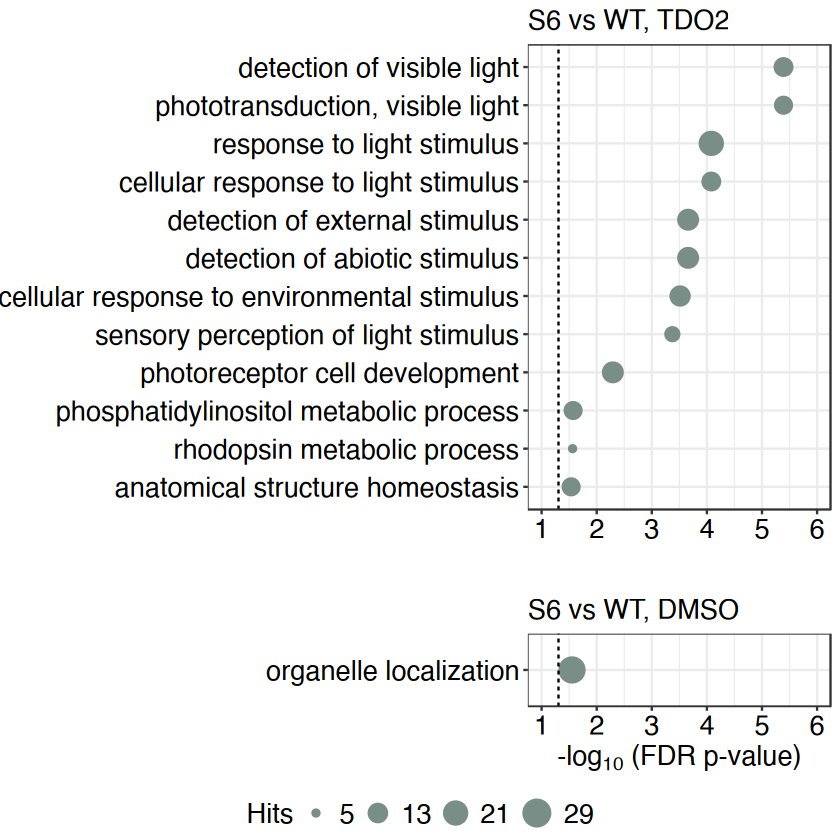

In [229]:
ggarrange(f.tdo, f.dmso, 
          ncol = 1, nrow = 2, 
          common.legend = T, 
          legend = "bottom", 
          align = "hv", 
          heights = c(4.5,1.5))

## Euler diagrams

In [230]:
library(eulerr)

Registered S3 method overwritten by 'eulerr':
  method    from  
  plot.venn gplots



S6 vs WT

In [231]:
overlap <- intersect(sig_tdo$gene, sig_dmso$gene)
unique.tdo <- setdiff(sig_tdo$gene, sig_dmso$gene)
unique.dmso <- setdiff(sig_dmso$gene, sig_tdo$gene)

In [232]:
print(length(intersect(sig_tdo$gene, sig_dmso$gene)))
l <- length(intersect(sig_tdo$gene, sig_dmso$gene))
print(length(sig_dmso$gene) - l)
print(length(sig_tdo$gene) - l)

[1] 889
[1] 733
[1] 571


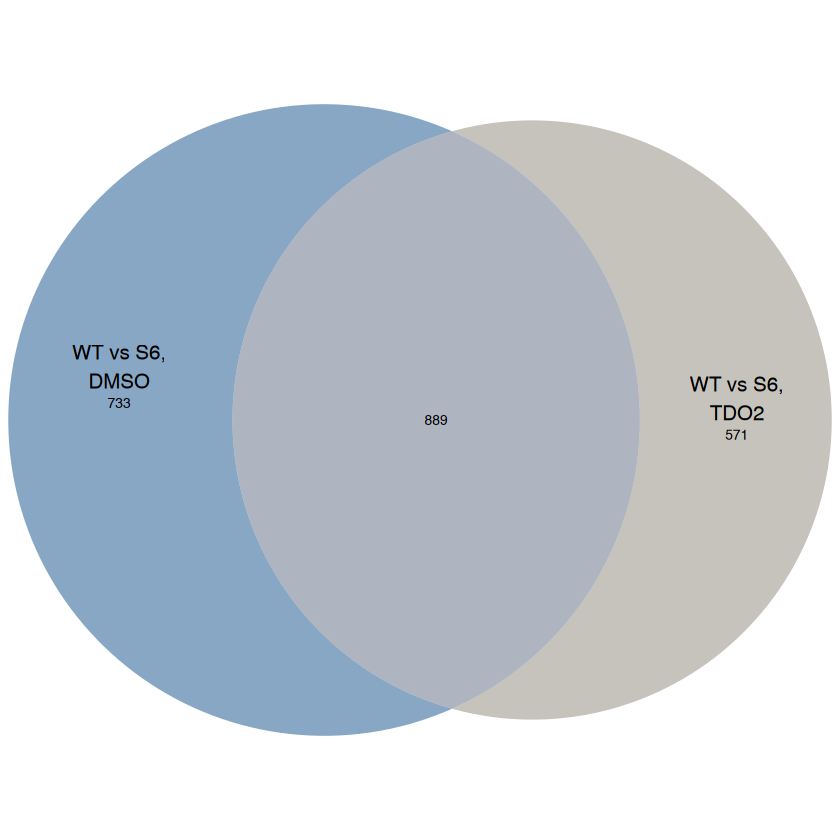

In [233]:
fit2 <- euler(c(DMSO = length(sig_dmso$gene) - l, TDO2 = length(sig_tdo$gene) - l, "DMSO&TDO2" = l))

plot(fit2, alpha = 0.5,
     fills = c("dodgerblue4", "cornsilk4"),
     labels = c('WT vs S6,\nDMSO', 'WT vs S6,\nTDO2'),
     edges = FALSE,
     fontsize = 15,
     quantities = list(fontsize = 8))

TDO2 vs DMSO

In [234]:
overlap <- intersect(sig_wt$gene, sig_s6$gene)
unique.s6 <- setdiff(sig_s6$gene, sig_wt$gene)
unique.wt <- setdiff(sig_wt$gene, sig_s6$gene)

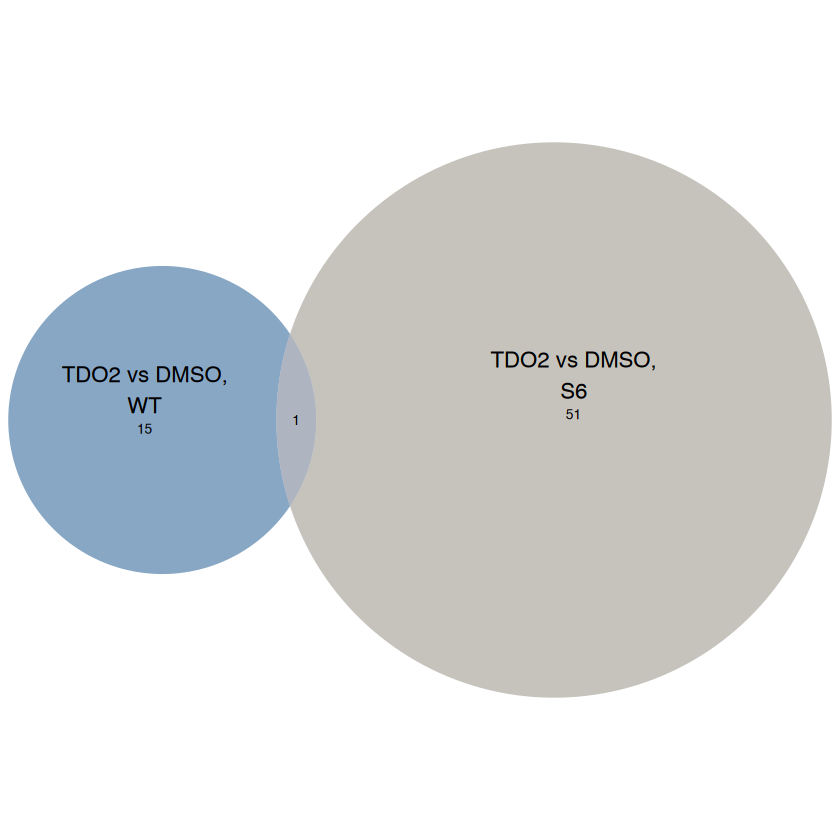

In [235]:
fit2 <- euler(c(WT = length(unique.wt), S6KO = length(unique.s6), "WT&S6KO" = length(overlap)))

plot(fit2, 
     alpha = 0.5,
     fills = c("dodgerblue4", "cornsilk4"),
     labels = list(labels = c('TDO2 vs DMSO,\nWT', 'TDO2 vs DMSO,\nS6'), fontsize = 13),
     edges = FALSE,
     fontsize = 15,
     quantities = list(fontsize = 8))

## Tryptophan transporter analysis

In [253]:
AA_ids <- read.table("../Data/Drosophila_experiment/FlyBase_AA_transporters_IDs.txt")$V1

In [254]:
aa_f_dmso <- res_dmso %>% as.data.frame() %>% filter(rownames(.) %in% AA_ids)
aa_f_tdo <- res_tdo %>% as.data.frame() %>% filter(rownames(.) %in% AA_ids)

In [255]:
aa_f_dmso <- aa_f_dmso %>% 
             rownames_to_column(var = "gene") %>% 
             left_join(., ann.data, by = c("gene" = "ENSEMBL"))

In [258]:
sig.vdata <- filter(aa_f_dmso, padj < 0.05 )
aa_f_dmso$Sig <- 'NS'
aa_f_dmso[((aa_f_dmso$padj < 0.05) & (aa_f_dmso$log2FoldChange < -0.58)), c(8)] <- 'Down'
aa_f_dmso[((aa_f_dmso$padj < 0.05) & (aa_f_dmso$log2FoldChange > 0.58)), c(8)] <- 'Up'

names.keyvals <- aa_f_dmso$Sig
names.keyvals[names.keyvals == 'NS'] <- 'grey'
names.keyvals[names.keyvals == 'Down'] <- wes_palette("IsleofDogs1")[1]
names.keyvals[names.keyvals == 'Up'] <- wes_palette("IsleofDogs2")[3]

names(names.keyvals) <- aa_f_dmso$Sig

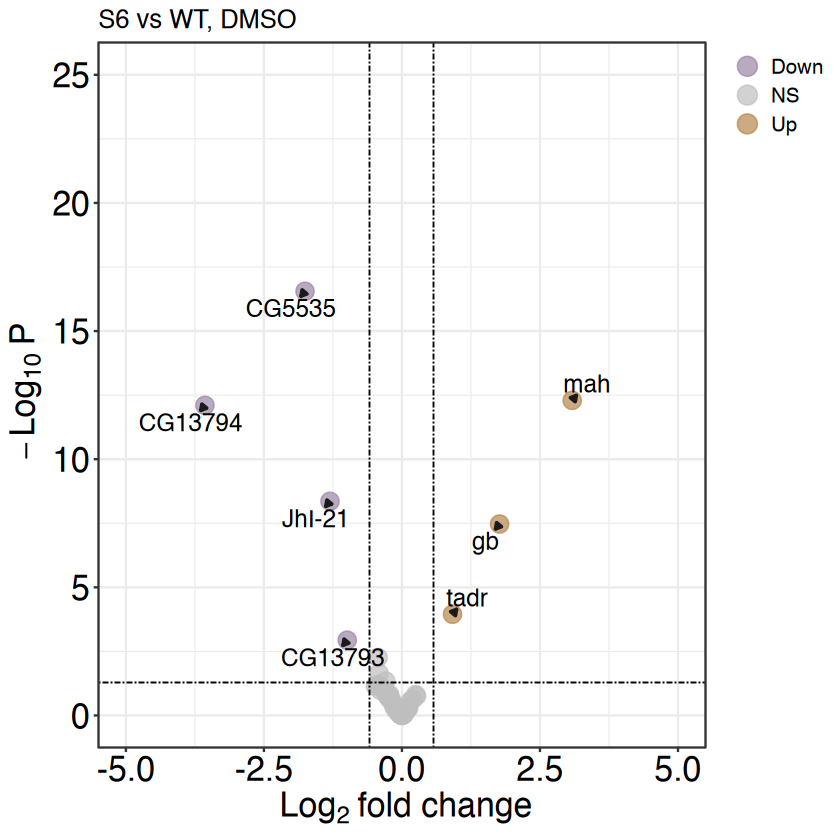

In [260]:
p1 <- EnhancedVolcano(aa_f_dmso, 
        lab = aa_f_dmso$gene_name,
        #selectLab = c('Kynurenic acid', 'Tryptophan', 'Kynurenine', 'Nicotinamide', 'NAD+'),
        x = 'log2FoldChange',
        y = 'padj',
        xlim = c(-5, 5),
        ylim = c(0, 25),
        title = NULL,
        #col = c('grey', 'grey', 'grey', '#D14f4f'),
    colCustom = names.keyvals,
    #shapeCustom = shapes.keyvals,
    cutoffLineType = 'twodash',
    subtitle = NULL,
    colAlpha = 0.7,
    pCutoff = 0.05,
    FCcutoff = 0.58,
    borderWidth = 0.02,
    pointSize = 4.5,
    drawConnectors = T,
    lengthConnectors = unit(0.01, "npc"),
    widthConnectors = 0.8,
    legendLabels=c('', 'Not sig', 'Sig'),
    caption = NULL,
    captionLabSize = 46,
    labSize = 5.)+
    ggtitle("S6 vs WT, DMSO")+
    theme_dose(20)+
    theme(legend.text=element_text(size=12), 
          legend.title = element_blank(), 
          legend.justification = c("right", "top"), plot.title = element_text(size = 15))

p1

In [299]:
sessionInfo()

R version 4.4.1 (2024-06-14)
Platform: aarch64-apple-darwin20
Running under: macOS Sonoma 14.5

Matrix products: default
BLAS:   /Library/Frameworks/R.framework/Versions/4.4-arm64/Resources/lib/libRblas.0.dylib 
LAPACK: /Library/Frameworks/R.framework/Versions/4.4-arm64/Resources/lib/libRlapack.dylib;  LAPACK version 3.12.0

locale:
[1] ru_RU.UTF-8/ru_RU.UTF-8/ru_RU.UTF-8/C/ru_RU.UTF-8/ru_RU.UTF-8

time zone: Europe/Moscow
tzcode source: internal

attached base packages:
[1] grid      stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] ComplexHeatmap_2.20.0       circlize_0.4.16            
 [3] eulerr_7.0.2                EnhancedVolcano_1.22.0     
 [5] ggrepel_0.9.6               ggpubr_0.6.0               
 [7] babelgene_22.9              edgeR_4.2.2                
 [9] clusterProfiler_4.12.6      org.Dm.eg.db_3.19.1        
[11] AnnotationDbi_1.66.0        reshape2_1.4.4             
[13] variancePartition_1.34.0    B